100%|██████████| 170498071/170498071 [00:02<00:00, 63452198.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


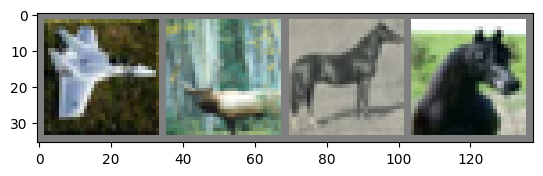

Epoch [1/5], Step [2000/12500], Loss: 1.9495257139205933
Epoch [1/5], Step [4000/12500], Loss: 1.2704503536224365
Epoch [1/5], Step [6000/12500], Loss: 1.0899341106414795
Epoch [1/5], Step [8000/12500], Loss: 0.6274029016494751
Epoch [1/5], Step [10000/12500], Loss: 1.3236641883850098
Epoch [1/5], Step [12000/12500], Loss: 2.140012264251709
Epoch [2/5], Step [2000/12500], Loss: 1.218842625617981
Epoch [2/5], Step [4000/12500], Loss: 0.9370816349983215
Epoch [2/5], Step [6000/12500], Loss: 0.7748887538909912
Epoch [2/5], Step [8000/12500], Loss: 1.3612555265426636
Epoch [2/5], Step [10000/12500], Loss: 0.15582811832427979
Epoch [2/5], Step [12000/12500], Loss: 1.421454668045044
Epoch [3/5], Step [2000/12500], Loss: 0.4187859892845154
Epoch [3/5], Step [4000/12500], Loss: 1.5030298233032227
Epoch [3/5], Step [6000/12500], Loss: 1.2337396144866943
Epoch [3/5], Step [8000/12500], Loss: 1.0773770809173584
Epoch [3/5], Step [10000/12500], Loss: 3.4196114540100098
Epoch [3/5], Step [12000/125

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 5
batch_size = 4
learning_rate = 0.01
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Tensors of normalized range [-1, 1]
'''Normalize does the following for each channel:
         image = (image - mean) / std

Color images have three channels (red, green, blue),
therefore you need three parameters to normalize each channel.
The first tuple (0.5, 0.5, 0.5) is the mean for all three channels and
the second (0.5, 0.5, 0.5) is the standard deviation for all three channels.
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(),transforms.RandomCrop(size=32)])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,padding=1)
#padding is done so that no loss of data of the pixle at boundary or corner
        self.pool = nn.MaxPool2d(2, 2)
#maxpool lowers down the matrix size i.e  calculates the maximum value for patches of a feature map, and uses it to create a downsampled (pooled) feature map
        self.conv2 = nn.Conv2d(64, 128, 3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3,padding=1)
        self.fc1 = nn.Linear(256*8*8, 200)
        self.fc2 = nn.Linear(200, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256*8*8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
'''[(N-K+2P)/S]+1 .
N is the input side
K is the Kernel size = 3 here.
P is the padding =1 .
S is the stride =1

using this we calculate the final size of a filter i.e 8*8 and 256 filters'''

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):


        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{steps}], Loss: {loss.item()}')



with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')